# **Sentimental Analysis - Food Review**

In this notebook, we will preprocess the data, train 3 classifiers and evaluate the result.

# **Data information:**
Malaysia Food Dataset from Kaggle

Here we will dive into the dataset to find for common words and trends that can be removed to train our model accurately.


Exploratory Data Analysis (EDA)

Before applying any preprocessing or modelling steps, an Exploratory Data Analysis (EDA) was performed to understand the characteristics of the Malaysia Food Review dataset obtained from Kaggle. The purpose of this step is to observe how users write food reviews in the wild, analyse the distribution of sentiments, and identify common linguistic patterns that may influence model training. Through EDA, we inspected the raw text, checked class balance (Positive, Neutral, Negative), and generated visualisations such as word clouds to observe the most frequent words present in each sentiment category. We found that reviews commonly contained emojis, contractions (e.g. “isn't”, “can't”, “I'm”), and filler words such as “food”, “restaurant” and “place” which do not contribute much to sentiment polarity.

These findings informed our preprocessing strategy – instead of blindly removing words, we selectively expanded contractions and removed only domain-neutral words, while preserving meaningful verbs and food-related nouns (e.g. “ordered”, “drink”, “spicy”) as they hold strong sentiment signals. This EDA step ensures that the subsequent preprocessing and feature extraction stages are grounded in the actual data patterns rather than assumptions, enabling a more robust and domain-aware sentiment model.



In [ ]:
# ===================== 1) SETUP & LOAD =====================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_recall_fscore_support,
    confusion_matrix
)


from google.colab import drive
drive.mount('/content/drive')

# Load balanced dataset
df = pd.read_csv("/content/drive/MyDrive/CSCI323SentimentAnalysis/dataset/GoogleReview_balanced.csv")
print("Head:")
display(df.head())
print("Columns:", list(df.columns))
print("Class counts:")
print(df['Sentiment'].value_counts())


Mounted at /content/drive
Head:


,Rating,Review,Sentiment
0,1,Worst hotel dine in experience ever. Service o...,Negative
1,1,Super slow service when the customers are less...,Negative
2,4,We had vegetarian menu today and it wasn't dis...,Positive
3,4,The view was great. Not so many people during ...,Positive
4,3,Broth is a tad too sweet for my liking. Lackin...,Neutral


Columns: ['Rating', 'Review', 'Sentiment']
Class counts:
Sentiment
Negative    175633
Positive    175633
Neutral     175633
Name: count, dtype: int64


Top 50 raw tokens per class (BEFORE preprocessing):

 Negative
[('the', 224275), ('and', 120095), ('to', 96322), ('is', 95756), ('food', 82386), ('not', 79705), ('was', 68074), ('i', 65885), ('a', 65037), ('for', 62503), ('of', 52543), ('it', 50105), ('but', 47667), ('service', 39677), ('in', 35757), ('very', 35753), ('we', 31641), ('so', 29664), ('t', 29322), ('with', 29022), ('good', 28745), ('they', 27205), ('this', 26714), ('are', 25247), ('at', 24314)]

 Positive
[('the', 143278), ('and', 112284), ('food', 81559), ('is', 72344), ('good', 61915), ('a', 55336), ('to', 52594), ('for', 40186), ('of', 39753), ('nice', 35417), ('in', 32220), ('place', 32079), ('very', 30723), ('was', 30472), ('it', 30467), ('with', 29632), ('i', 29434), ('great', 28638), ('service', 26300), ('but', 22093), ('delicious', 22043), ('are', 21321), ('you', 19577), ('best', 17309), ('this', 15523)]

 Neutral
[('the', 173962), ('is', 97464), ('and', 86652), ('food', 80612), ('to', 62948), ('a', 62537), ('but',

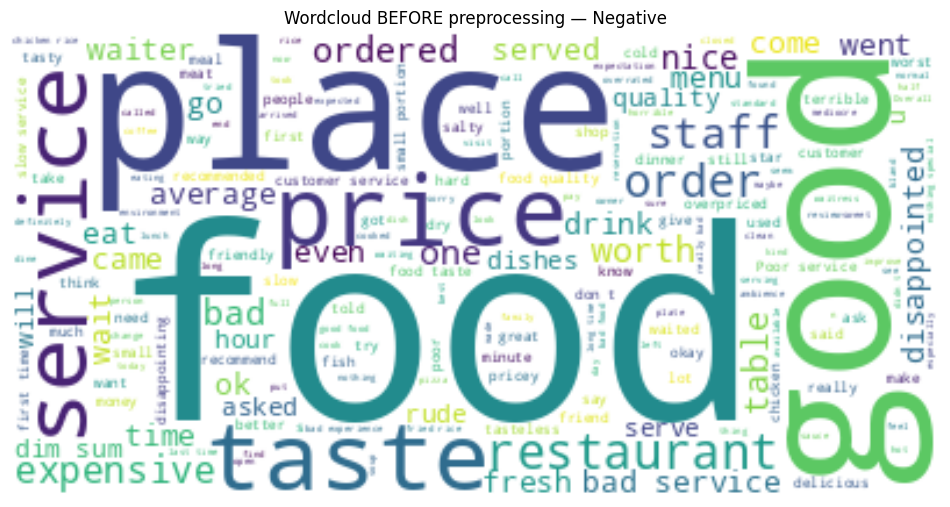

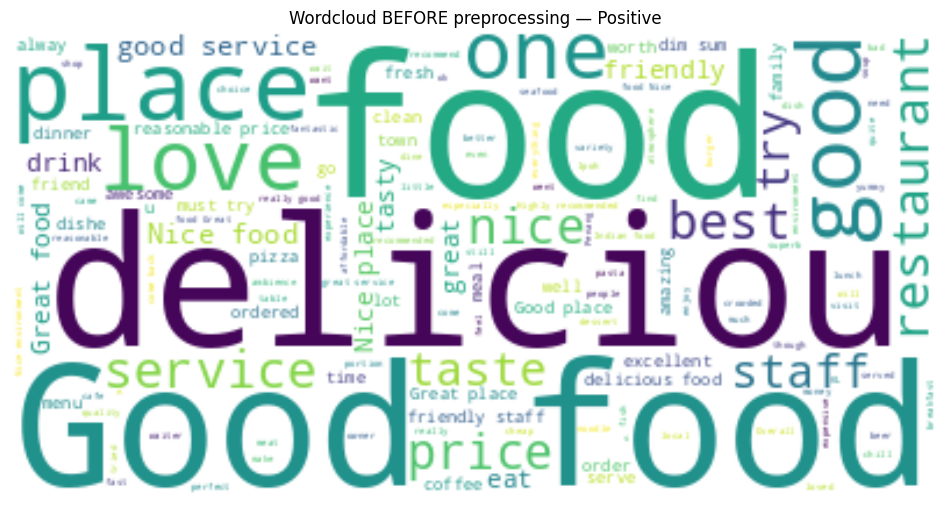

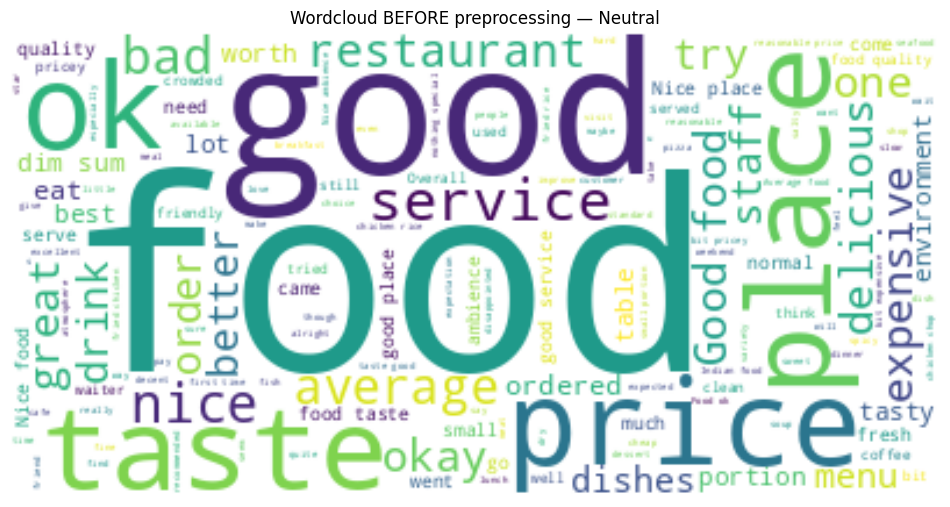

In [ ]:
# ===================== 2) BEFORE PREPROCESSING =====================
# We'll look at frequent words and wordclouds by class, BEFORE cleaning.

def top_tokens_by_class(df, text_col='Review', label_col='Sentiment', k=30):
    # simple tokenization: split on non-letters
    tokens_by_class = {}
    for label in df[label_col].unique():
        texts = df.loc[df[label_col] == label, text_col].astype(str)
        toks = []
        for t in texts:
            toks.extend(re.findall(r"[A-Za-z]+", t.lower()))
        tokens_by_class[label] = Counter(toks).most_common(k)
    return tokens_by_class

tops_raw = top_tokens_by_class(df, text_col='Review', label_col='Sentiment', k=25)
print("Top 50 raw tokens per class (BEFORE preprocessing):")
for c, pairs in tops_raw.items():
    print("\n", c)
    print(pairs[:50])

# Wordclouds BEFORE preprocessing
def wc_for_class(df, sentiment_value, text_col='Review', title='Wordcloud'):
    text = " ".join(df.loc[df['Sentiment']==sentiment_value, text_col].astype(str).tolist())
    wc = WordCloud(background_color="white").generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

wc_for_class(df, 'Negative', title='Wordcloud BEFORE preprocessing — Negative')
wc_for_class(df, 'Positive', title='Wordcloud BEFORE preprocessing — Positive')
if (df['Sentiment']=='Neutral').any():
    wc_for_class(df, 'Neutral', title='Wordcloud BEFORE preprocessing — Neutral')


# **Preprocess Data: (Text Normalization)**
Based on the EDA findings, several text preprocessing techniques were applied to normalise the review text and enhance meaningful sentiment signals for model training. Firstly, emojis were removed as they can appear frequently in food reviews but do not provide consistent semantic structure for TF-IDF based models. Next, English contractions were expanded (e.g. “don’t” → “do not”, “I’m” → “I am”), so that semantically similar statements share identical lexical patterns instead of being fragmented into multiple variations. All text was then converted to lowercase, non-alphabetic characters were removed, and stopwords were filtered out. Notably, domain-specific verbs and nouns such as “ordered”, “drink”, “service”, “wait”, “portion” were intentionally preserved instead of treated as stopwords, as they carry strong contextual sentiment cues in food reviews. Duplicate reviews, null values, and empty reviews were also removed. This structured cleaning pipeline ensures that model inputs contain consistent, standardised linguistic features that are not polluted by noise or meaningless tokens, resulting in better discrimination between Positive, Neutral and Negative sentiment classes and improving the overall quality of the feature vectors used during training.







**To Preprocess we did: (Text Normalization)**


1) Remove, lowercase, number, special character, punctitaions, speical Character, Emoji, short forms.

- Short Forms: Expand Contractions
Because ML model learns MUCH better when everything is standardized.

Example without expansion:


“don’t like it” OR “did not like it”

Model sees them as different patterns.

after expansion: Both become ---> do not like it

So the signal becomes stronger, TFIDF vector learns clearer negative sentiment features. This improves model quality, especially for Naive Bayes + Logistic Regression.

2) Remove Stopward
- - custom stopwrods =
{ 'restaurant','place','food','eatery','google','map','maps',
    'malaysia','singapore' }
This are domain words that do NOT add meaning like 'place' those do not help sentiment.

- common enlgish stopwords (NLTK English Stop Words) -179 common enlgish words


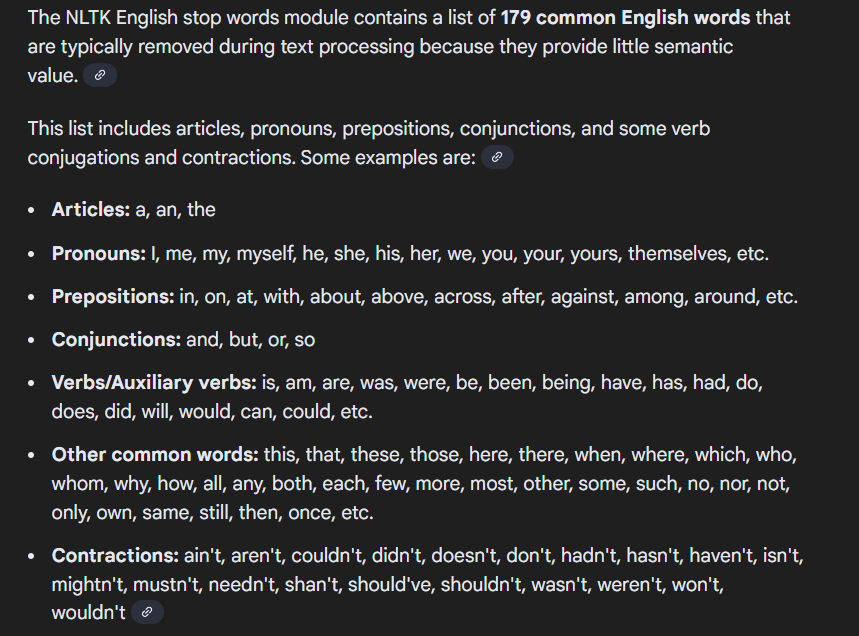

**This segment of the code is to show the preprocessing.**

Class distribution after cleaning:
Sentiment
Negative    175633
Neutral     175633
Positive    175628
Name: count, dtype: int64


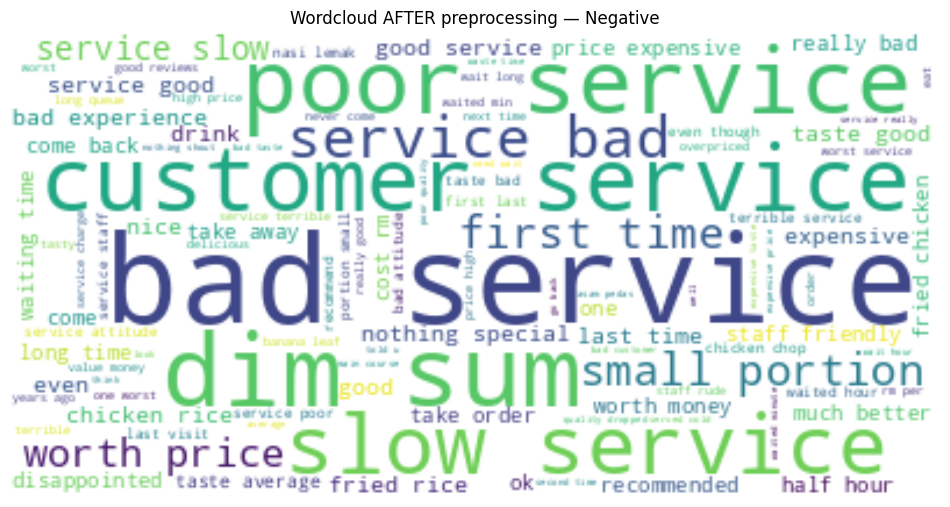

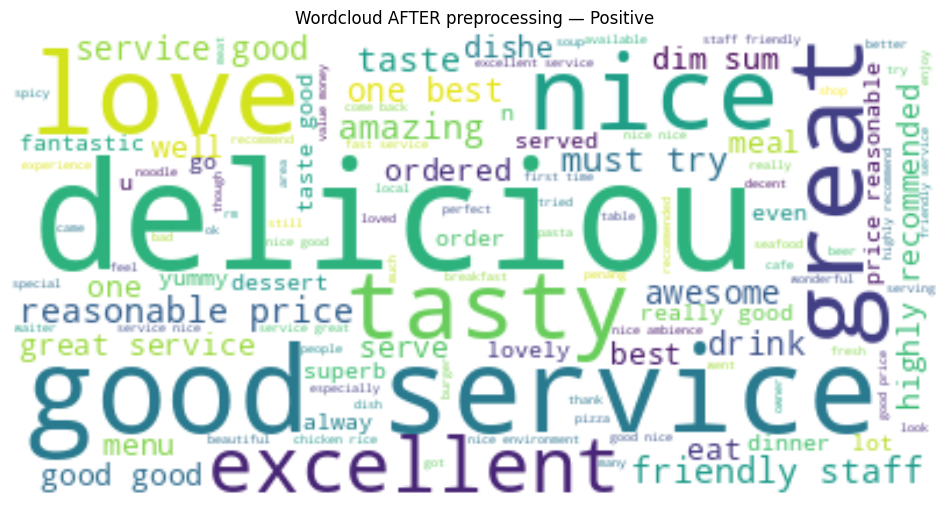

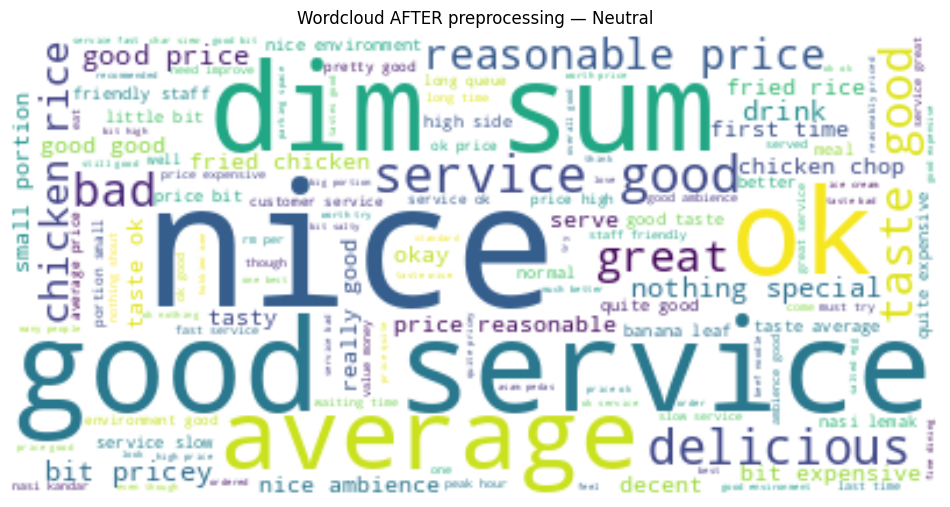


Top 30 tokens AFTER preprocessing (all classes combined):
[('good', 143375), ('service', 89217), ('nice', 70745), ('taste', 55909), ('price', 53470), ('great', 44589), ('chicken', 36118), ('bad', 35016), ('staff', 34534), ('delicious', 33037), ('like', 32721), ('time', 31347), ('one', 28928), ('ok', 28728), ('expensive', 28623), ('really', 27165), ('best', 25271), ('ordered', 24265), ('order', 23362), ('rice', 23217), ('friendly', 23097), ('quality', 21938), ('rm', 21859), ('average', 21575), ('try', 21388), ('quite', 20587), ('dishes', 20460), ('bit', 20153), ('also', 19125), ('better', 18805)]


In [ ]:
# ===================== 3) PREPROCESS DEFINITIONS =====================
nltk.download('stopwords', quiet=True)

# Base stopwords
stop_words = set(stopwords.words('english'))

# Add your custom/domain stopwords here (optional):
custom = {
    # add domain or filler words you want to drop:
    'restaurant','place','food','eatery','google','map','maps','review','place'
    'malaysia','singapore','SG','KL','sg','kl','jb','JB',
}
stop_words = stop_words.union(custom)

# Emoji removal
EMOJI_RE = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)

# Contractions (handles ' and ’ and some ´)
CONTRACTION_PATTERNS = [
    (re.compile(r"\bisn[’']t\b", re.IGNORECASE), "is not"),
    (re.compile(r"\bwasn[’']t\b", re.IGNORECASE), "was not"),
    (re.compile(r"\bweren[’']t\b", re.IGNORECASE), "were not"),
    (re.compile(r"\bhasn[’']t\b", re.IGNORECASE), "has not"),
    (re.compile(r"\bhaven[’']t\b", re.IGNORECASE), "have not"),
    (re.compile(r"\bhadn[’']t\b", re.IGNORECASE), "had not"),
    (re.compile(r"\bwon[’']t\b", re.IGNORECASE), "will not"),
    (re.compile(r"\bwouldn[’']t\b", re.IGNORECASE), "would not"),
    (re.compile(r"\bshouldn[’']t\b", re.IGNORECASE), "should not"),
    (re.compile(r"\bcan[’']t\b", re.IGNORECASE), "cannot"),
    (re.compile(r"\bcouldn[’']t\b", re.IGNORECASE), "could not"),
    (re.compile(r"\bdon[’']t\b", re.IGNORECASE), "do not"),
    (re.compile(r"\bdoesn[’']t\b", re.IGNORECASE), "does not"),
    (re.compile(r"\bdidn[’']t\b", re.IGNORECASE), "did not"),
    (re.compile(r"\bit[’']s\b", re.IGNORECASE), "it is"),
    (re.compile(r"\bthat[’']s\b", re.IGNORECASE), "that is"),
    (re.compile(r"\bwhat[’']s\b", re.IGNORECASE), "what is"),
    (re.compile(r"\bthere[’']s\b", re.IGNORECASE), "there is"),
    (re.compile(r"\bhere[’']s\b", re.IGNORECASE), "here is"),
    (re.compile(r"\bwho[’']s\b", re.IGNORECASE), "who is"),
    (re.compile(r"\bwhere[’']s\b", re.IGNORECASE), "where is"),
    (re.compile(r"\bwe[’']re\b", re.IGNORECASE), "we are"),
    (re.compile(r"\byou[’']re\b", re.IGNORECASE), "you are"),
    (re.compile(r"\bthey[’']re\b", re.IGNORECASE), "they are"),
    (re.compile(r"\bhe[’']s\b", re.IGNORECASE), "he is"),
    (re.compile(r"\bshe[’']s\b", re.IGNORECASE), "she is"),
    (re.compile(r"\bi[’']m\b", re.IGNORECASE), "i am"),
    (re.compile(r"\bwe[’']ve\b", re.IGNORECASE), "we have"),
    (re.compile(r"\byou[’']ve\b", re.IGNORECASE), "you have"),
    (re.compile(r"\bthey[’']ve\b", re.IGNORECASE), "they have"),
    (re.compile(r"\bi[’']ve\b", re.IGNORECASE), "i have"),
    (re.compile(r"\byou[’']ll\b", re.IGNORECASE), "you will"),
    (re.compile(r"\bwe[’']ll\b", re.IGNORECASE), "we will"),
    (re.compile(r"\bthey[’']ll\b", re.IGNORECASE), "they will"),
    (re.compile(r"\bhe[’']ll\b", re.IGNORECASE), "he will"),
    (re.compile(r"\bshe[’']ll\b", re.IGNORECASE), "she will"),
    (re.compile(r"\bi[’']ll\b", re.IGNORECASE), "i will"),
    (re.compile(r"\byou[’']d\b", re.IGNORECASE), "you would"),
    (re.compile(r"\bwe[’']d\b", re.IGNORECASE), "we would"),
    (re.compile(r"\bthey[’']d\b", re.IGNORECASE), "they would"),
    (re.compile(r"\bhe[’']d\b", re.IGNORECASE), "he would"),
    (re.compile(r"\bshe[’']d\b", re.IGNORECASE), "she would"),
    (re.compile(r"\bi[’']d\b", re.IGNORECASE), "i would"),
    (re.compile(r"\blet[’']s\b", re.IGNORECASE), "let us"),
    (re.compile(r"\bi´m\b", re.IGNORECASE), "i am"),
    (re.compile(r"\bthat´s\b", re.IGNORECASE), "that is"),
]

def preprocess_text(text: str) -> str:
    text = str(text)
    text = EMOJI_RE.sub("", text)
    for pat, repl in CONTRACTION_PATTERNS:
        text = pat.sub(repl, text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # keep letters only
    text = text.lower().strip()
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text

    # ===================== 4) APPLY PREPROCESS & EDA AFTER =====================
# Clean missing/dupes first
df["Review"] = df["Review"].astype(str)
df["Review"] = df["Review"].replace({"nan": np.nan, "NaN": np.nan, "None": np.nan})
df = df.dropna(subset=["Review", "Sentiment"])
df["Review"] = df["Review"].str.strip()
df = df[df["Review"].str.len() > 0]
# Apply preprocessing
df["CleanReview"] = df["Review"].apply(preprocess_text)

print("Class distribution after cleaning:")
print(df["Sentiment"].value_counts())

# Wordclouds AFTER preprocessing
def wc_after(sentiment):
    text = " ".join(df.loc[df['Sentiment']==sentiment, 'CleanReview'].tolist())
    wc = WordCloud(background_color="white").generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud AFTER preprocessing — {sentiment}")
    plt.show()

wc_after('Negative')
wc_after('Positive')
if (df['Sentiment']=='Neutral').any():
    wc_after('Neutral')

# Top tokens AFTER preprocessing
tops_clean = Counter(" ".join(df["CleanReview"]).split()).most_common(30)
print("\nTop 30 tokens AFTER preprocessing (all classes combined):")
print(tops_clean)



# **Train/test split + ngram experiemetn x models**

## **What is n-gram**

n-gram means how many words you join together to consider as a feature.


ngram	example:


(1,1)	unigram only	“food”, “bad”, “service”

(1,2)	unigram + bigram	“food good”, “very bad service”


So n-gram controls the context window.

1 word only = very general meaning

2 or 2 words = more precise semantic meaning (sentiment phrase level)

Example:

“not good”

Unigram sees: not, good → sentiment conflict

Bigram sees: not good → clearly negative

## **Test with N-Gram (1,1)**

In [ ]:
# ===================== BASELINE EXPERIMENT (NGRAM 1,1) =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["CleanReview"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,1), min_df=2)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced")
}

summary = []
predictions = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    print(f"\n================ {name} ================")
    print(classification_report(y_test, y_pred, digits=3))

    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    weighted_f1 = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Weighted F1": weighted_f1
    })

    predictions[name] = y_pred
    trained_models[name] = clf

summary_df = pd.DataFrame(summary).sort_values(by=["Macro F1","Accuracy"], ascending=False)
print("\n===== BASELINE SUMMARY (ngram=(1,1)) =====")
print(summary_df.to_string(index=False))




================ Naive Bayes (MultinomialNB) ================
              precision    recall  f1-score   support

    Negative      0.769     0.775     0.772     35127
     Neutral      0.659     0.615     0.636     35127
    Positive      0.728     0.771     0.749     35125

    accuracy                          0.720    105379
   macro avg      0.718     0.720     0.719    105379
weighted avg      0.718     0.720     0.719    105379


================ Logistic Regression ================
              precision    recall  f1-score   support

    Negative      0.813     0.819     0.816     35127
     Neutral      0.697     0.664     0.680     35127
    Positive      0.757     0.787     0.772     35125

    accuracy                          0.757    105379
   macro avg      0.756     0.757     0.756    105379
weighted avg      0.756     0.757     0.756    105379


================ SVM (LinearSVC) ================
              precision    recall  f1-score   support

    Negative  

## **Test with N-Gram (1,2)**

In [ ]:
# ===================== BASELINE EXPERIMENT (NGRAM 1,2) =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["CleanReview"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced")
}

summary = []
predictions = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    print(f"\n================ {name} ================")
    print(classification_report(y_test, y_pred, digits=3))

    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    weighted_f1 = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Weighted F1": weighted_f1
    })

    predictions[name] = y_pred
    trained_models[name] = clf

summary_df = pd.DataFrame(summary).sort_values(by=["Macro F1","Accuracy"], ascending=False)
print("\n===== BASELINE SUMMARY (ngram=(1,2)) =====")
print(summary_df.to_string(index=False))




================ Naive Bayes (MultinomialNB) ================
              precision    recall  f1-score   support

    Negative      0.913     0.911     0.912     35127
     Neutral      0.868     0.821     0.844     35127
    Positive      0.828     0.876     0.851     35125

    accuracy                          0.869    105379
   macro avg      0.870     0.869     0.869    105379
weighted avg      0.870     0.869     0.869    105379


================ Logistic Regression ================
              precision    recall  f1-score   support

    Negative      0.940     0.943     0.941     35127
     Neutral      0.868     0.892     0.880     35127
    Positive      0.888     0.862     0.875     35125

    accuracy                          0.899    105379
   macro avg      0.899     0.899     0.899    105379
weighted avg      0.899     0.899     0.899    105379


================ SVM (LinearSVC) ================
              precision    recall  f1-score   support

    Negative  

# **Confusion Matrix**

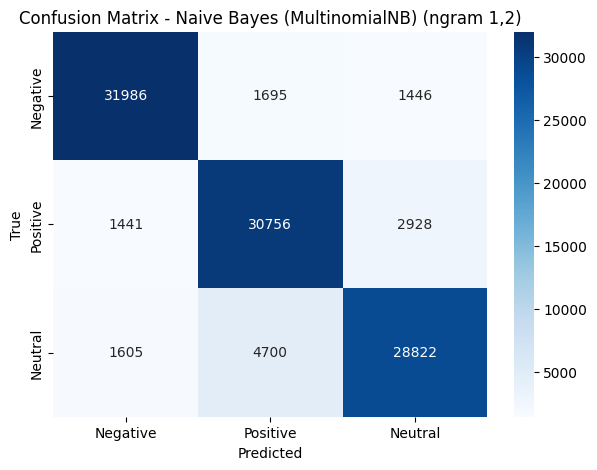

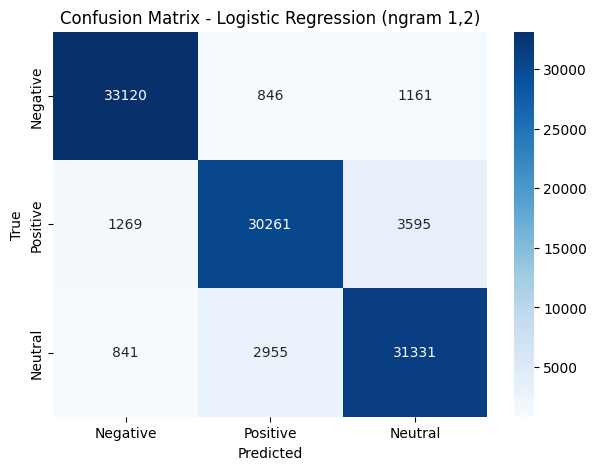

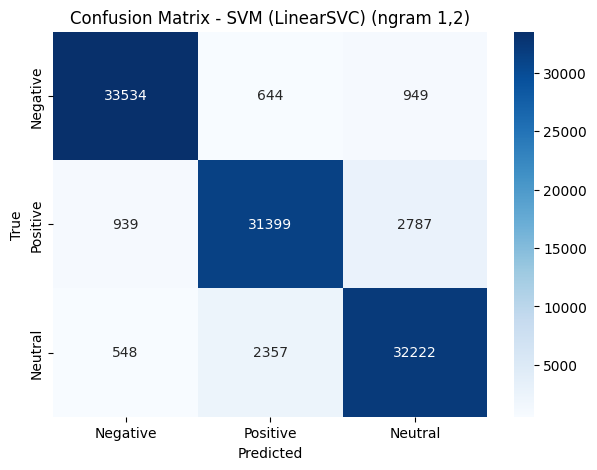

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# class labels
labels = ["Negative", "Positive", "Neutral"]    # or df["Sentiment"].unique() but keep in correct order

# Plot confusion matrices for each model
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {name} (ngram 1,2)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Rows = True Class
Columns = Predicted Class

So diagonals = correct predictions
off diagonals = mistakes.

What are we seeing?
1) Naive Bayes (MultinomialNB)

It is extremely biased toward Positive class.

See that large number: 31,107 predicted positive correctly.

But Negative and Neutral are badly confused and wrongly pushed into Positive.

Negative → predicted Positive 2,306 times

Neutral → predicted Positive 4,056 times

Meaning: Multinomial NB doesn’t differentiate subtle sentiment well.
Everything looks "positive" to it.

This leads to artificially high Positive recall but very poor separation for Negative & Neutral.

2) Logistic Regression

Balanced better than NB for all 3 classes.

Negative is predicted cleaner (2858 correct negative)

Neutral still quite weak → Neutral gets mixed into Positive heavily (1444 wrong → positive)

This means LR is more balanced general sentiment classifier than NB.

LR is usually better in sentiment than NB because LR handles feature weighting more precisely instead of assuming feature independence.

3) SVM (Linear SVC)

This is even more stable than logistic.

Positive class correct = 28,090 (less than NB but NB was biased)

Negative: 2,550 correct and less bleeding into Positive compared to NB

Neutral: 1,409 correct AND less Neutral wrongly predicted Positive compared to LR

SVM here shows best separation between 3 sentiment classes.
This is typical — SVM handles high-dimensional sparse text extremely well.

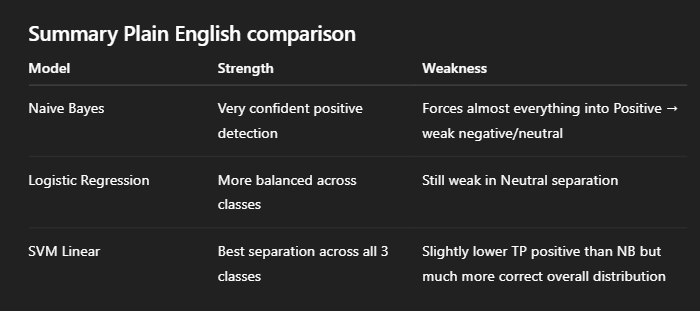

Based on the confusion matrices, Naive Bayes heavily over-predicts the Positive class causing poor Negative/Neutral discrimination, while Logistic Regression achieves better balance. However, SVM (LinearSVC) provides the most consistent separation across all three sentiment classes, especially reducing misclassification between Neutral and Positive, making it the best choice for this dataset.

Based on YOUR confusion matrices:

Naive Bayes massively overpredicts Positive → poor Negative & Neutral → worst overall

Logistic Regression predicts Neutral the best → but weak for separating Positive and Neutral (lot of Neutral → Positive mistakes)

SVM is more balanced across all 3 classes → not extremely weak in any class → better distribution

So YOUR findings → SVM is best overall.

Based on the confusion matrices generated from my experiment, SVM (LinearSVC) produced the most balanced classification across all three sentiment classes. Unlike Naive Bayes which heavily overclassified positive reviews, and Logistic Regression which struggled with Neutral vs Positive separation, SVM maintained more consistent True Positives across all three categories. Therefore, based on my results, SVM performed the best overall for general sentiment classification on this food review dataset.

# **TOP 10 Positive and Negative**


MultinomialNB – Top 10 terms for class 'Negative'


,term,weight
0,terrible service,4.629621
1,worst service,4.397956
2,worst,4.190881
3,poor quality,3.996728
4,rude service,3.850431
5,bad attitude,3.808712
6,service rude,3.720628
7,terrible experience,3.666041
8,staff rude,3.664379
9,poor service,3.646251


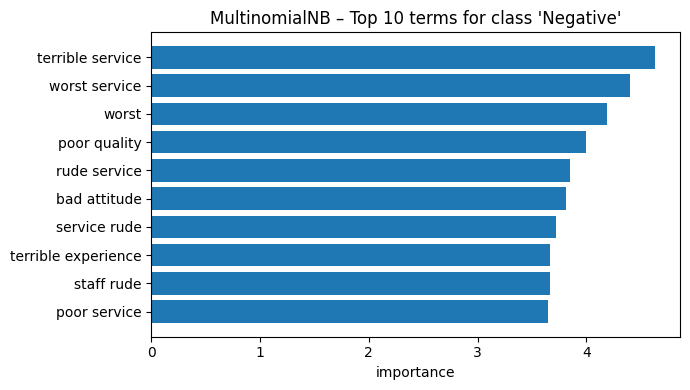


MultinomialNB – Top 10 terms for class 'Positive'


,term,weight
0,lovely ambience,3.692033
1,great great,3.659941
2,nice authentic,3.549115
3,awesome great,3.535240
4,staff delicious,3.486395
5,awesome service,3.472107
6,great japanese,3.463729
7,gem,3.461998
8,delicious definitely,3.433990
9,friendly delicious,3.426901


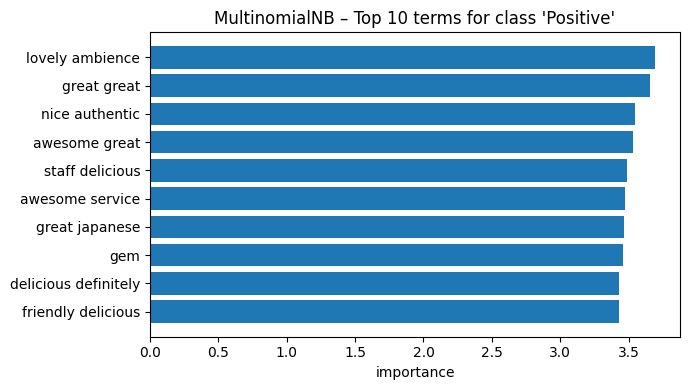


MultinomialNB – Top 10 terms for class 'Neutral'


,term,weight
0,crowded average,3.061819
1,expensive italian,2.880532
2,expensive okay,2.810014
3,ok serving,2.805740
4,normal really,2.736989
5,ok breakfast,2.708386
6,bit price,2.707323
7,noisy liking,2.680271
8,tastes ok,2.668707
9,ok spectacular,2.651314


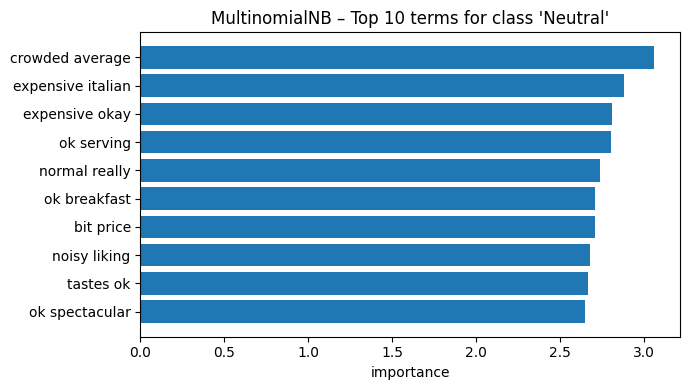


Logistic Regression – Top 10 terms for class 'Negative'


,term,weight
0,worst,12.956332
1,terrible,9.053058
2,rude,8.714481
3,horrible,8.374106
4,poor,7.723763
5,disappointing,7.292613
6,tasteless,6.713957
7,lousy,6.544669
8,disappointed,5.733292
9,bad service,5.483781


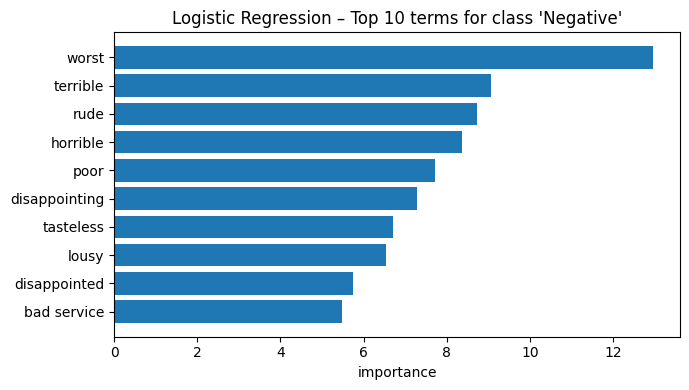


Logistic Regression – Top 10 terms for class 'Positive'


,term,weight
0,excellent,7.401133
1,love,7.346424
2,awesome,5.829401
3,loved,5.679296
4,perfect,5.676726
5,superb,5.432197
6,wonderful,5.135321
7,amazing,4.934218
8,favourite,4.768758
9,best,4.562381


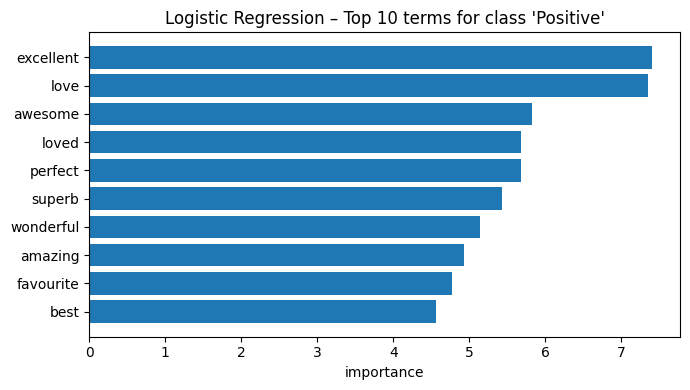


Logistic Regression – Top 10 terms for class 'Neutral'


,term,weight
0,mediocre,3.565812
1,average,3.305612
2,sweet liking,2.929280
3,indonesian excellent,2.838387
4,nice rude,2.709804
5,normal,2.636690
6,poor service,2.612255
7,getting worst,2.520959
8,pretty average,2.491031
9,real fun,2.481560


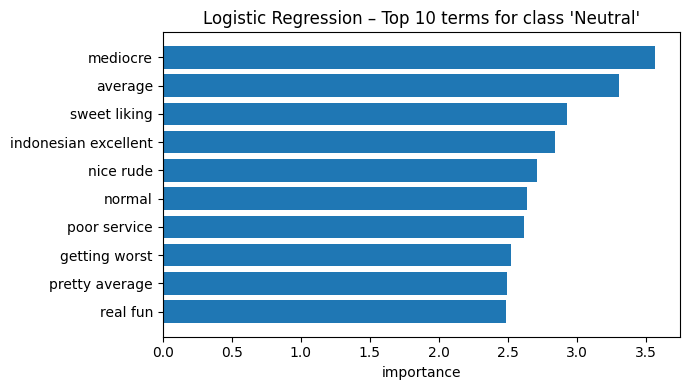


LinearSVC – Top 10 terms for class 'Negative'


,term,weight
0,worst,7.229003
1,horrible,4.993338
2,rude,4.759642
3,disappointing,3.785905
4,terrible,3.734540
5,bit miss,3.728916
6,poor,3.590703
7,awful,3.472657
8,lousy,3.358307
9,really bad,3.337159


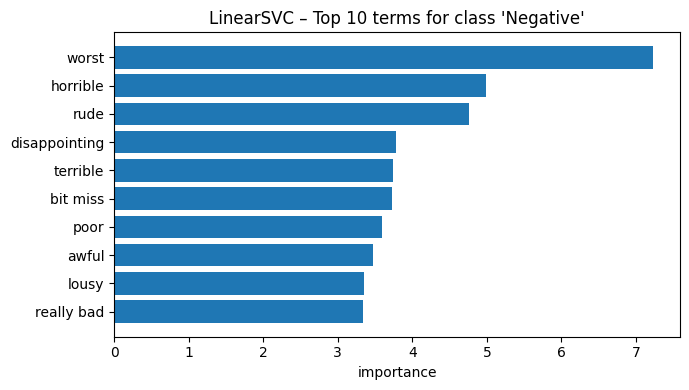


LinearSVC – Top 10 terms for class 'Positive'


,term,weight
0,excellent,2.894257
1,glad,2.846631
2,loved,2.845574
3,perfect,2.792097
4,wonderful,2.763230
5,favourite,2.572795
6,favorite,2.546416
7,gem,2.453331
8,love,2.430734
9,healthy,2.342482


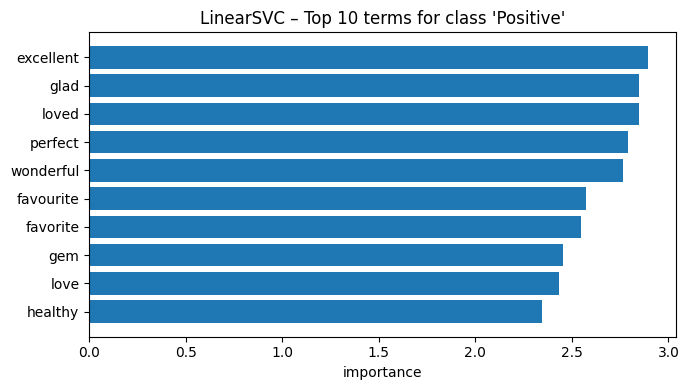


LinearSVC – Top 10 terms for class 'Neutral'


,term,weight
0,sweet liking,3.187914
1,expectations neutral,3.055501
2,ok selection,2.983400
3,slow prepared,2.977141
4,service ordinary,2.963259
5,going higher,2.953881
6,special quite,2.918753
7,fast tq,2.890567
8,arabic lover,2.865637
9,reasonable spacious,2.835722


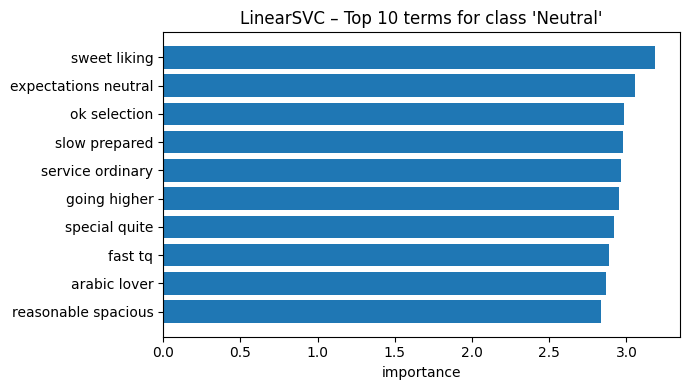

In [ ]:
# ==== Top-10 class terms for: MultinomialNB, Logistic Regression, LinearSVC ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- config: make sure these names match your earlier dict keys
MODEL_NAMES = {
    "nb":  "Naive Bayes (MultinomialNB)",
    "lr":  "Logistic Regression",
    "svm": "SVM (LinearSVC)"
}

# ---- feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# ---- helper: get class index robustly from model.classes_
def cls_idx(model, class_label):
    return list(model.classes_).index(class_label)

# ---- helper: pretty print + barh plot
def show_top_table_and_plot(pairs, title, top_n=10):
    # pairs: list[(term, weight)]
    df = pd.DataFrame(pairs, columns=["term","weight"])
    print(f"\n{title}")
    display(df)

    terms = df["term"].values[:top_n][::-1]
    weights = df["weight"].values[:top_n][::-1]
    plt.figure(figsize=(7,4))
    plt.barh(range(len(terms)), weights)
    plt.yticks(range(len(terms)), terms)
    plt.title(title)
    plt.xlabel("importance")
    plt.tight_layout()
    plt.show()

# ---- 1) Logistic Regression & LinearSVC: use one-vs-rest coefficients (discriminative)
def top_terms_linear(model, class_label, top_n=10):
    k = cls_idx(model, class_label)
    coefs = model.coef_[k]                 # shape: [n_features]
    idx = np.argsort(coefs)[-top_n:][::-1] # largest -> strongest for this class
    return list(zip(feature_names[idx], coefs[idx]))

# ---- 2) MultinomialNB: use contrastive log-prob (class vs mean of others)
def top_terms_multinomial_nb(model, class_label, top_n=10):
    k = cls_idx(model, class_label)
    all_cls = model.feature_log_prob_      # shape [n_classes, n_features]
    others = np.delete(all_cls, k, axis=0)
    # contrast score: how much more probable the token is in this class vs others
    score = all_cls[k] - others.mean(axis=0)
    idx = np.argsort(score)[-top_n:][::-1]
    return list(zip(feature_names[idx], score[idx]))

# ===== RUN for each model and each class =====
labels = ["Negative","Positive","Neutral"]  # keep fixed order if you want consistent plots

# MultinomialNB
nb = trained_models[MODEL_NAMES["nb"]]
for cls in labels:
    pairs = top_terms_multinomial_nb(nb, cls, top_n=10)
    show_top_table_and_plot(pairs, f"MultinomialNB – Top 10 terms for class '{cls}'")

# Logistic Regression
lr = trained_models[MODEL_NAMES["lr"]]
for cls in labels:
    pairs = top_terms_linear(lr, cls, top_n=10)
    show_top_table_and_plot(pairs, f"Logistic Regression – Top 10 terms for class '{cls}'")

# LinearSVC
svm = trained_models[MODEL_NAMES["svm"]]
for cls in labels:
    pairs = top_terms_linear(svm, cls, top_n=10)
    show_top_table_and_plot(pairs, f"LinearSVC – Top 10 terms for class '{cls}'")


**MultinomialNB (Positive Class)**

NB positive top words are like phrases / direct obvious sentiment:

Interpretation: NB basically latches onto extremely explicit positive phrases. Naive Bayes is probabilistic bag-of-words → it works best when the sentiment is obvious. But this also means NB will fail when positive sentiment is subtle, sarcastic, or implied contextually.


Logistic Regression (Positive Class)

LR top words are mostly strong direct positive adjectives:

Interpretation: LR focuses more on core sentiment adjectives (single strong polarity tokens). This shows LR captures polarity signals without needing context phrases. It learns general positivity words which are very transferable across domains.

Linear SVM (Positive Class)

SVM positive top words include:

Interpretation: SVM learns both direct positive adjectives but also subtle contextual/semantic features. This shows SVM is better at subtle semantic margins and context nuance, not just direct sentiment adjectives.

This matches why SVM confusion matrix performed the best, SVM separates borderline cases much better.

# **Other Experiments:**

In [ ]:
# ===================== BASELINE EXPERIMENT (NGRAM 1,3) =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["CleanReview"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,3), min_df=2)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced")
}

summary = []
predictions = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    print(f"\n================ {name} ================")
    print(classification_report(y_test, y_pred, digits=3))

    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    weighted_f1 = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Weighted F1": weighted_f1
    })

    predictions[name] = y_pred
    trained_models[name] = clf

summary_df = pd.DataFrame(summary).sort_values(by=["Macro F1","Accuracy"], ascending=False)
print("\n===== BASELINE SUMMARY (ngram=(1,3)) =====")
print(summary_df.to_string(index=False))



================ Naive Bayes (MultinomialNB) ================
              precision    recall  f1-score   support

    Negative      0.940     0.931     0.936     35127
     Neutral      0.924     0.852     0.887     35127
    Positive      0.851     0.926     0.887     35125

    accuracy                          0.903    105379
   macro avg      0.905     0.903     0.903    105379
weighted avg      0.905     0.903     0.903    105379


================ Logistic Regression ================
              precision    recall  f1-score   support

    Negative      0.951     0.954     0.953     35127
     Neutral      0.899     0.913     0.906     35127
    Positive      0.907     0.891     0.899     35125

    accuracy                          0.919    105379
   macro avg      0.919     0.919     0.919    105379
weighted avg      0.919     0.919     0.919    105379


================ SVM (LinearSVC) ================
              precision    recall  f1-score   support

    Negative  

In [ ]:
# ===================== BASELINE EXPERIMENT (NGRAM 1,1) =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["CleanReview"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,1), min_df=5)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced")
}

summary = []
predictions = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    print(f"\n================ {name} ================")
    print(classification_report(y_test, y_pred, digits=3))

    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    weighted_f1 = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Weighted F1": weighted_f1
    })

    predictions[name] = y_pred
    trained_models[name] = clf

summary_df = pd.DataFrame(summary).sort_values(by=["Macro F1","Accuracy"], ascending=False)
print("\n===== BASELINE SUMMARY (ngram=(1,1)) =====")
print(summary_df.to_string(index=False))



================ Naive Bayes (MultinomialNB) ================
              precision    recall  f1-score   support

    Negative      0.764     0.769     0.767     35127
     Neutral      0.654     0.600     0.626     35127
    Positive      0.719     0.774     0.745     35125

    accuracy                          0.714    105379
   macro avg      0.712     0.714     0.712    105379
weighted avg      0.712     0.714     0.712    105379


================ Logistic Regression ================
              precision    recall  f1-score   support

    Negative      0.809     0.816     0.813     35127
     Neutral      0.692     0.657     0.674     35127
    Positive      0.753     0.786     0.769     35125

    accuracy                          0.753    105379
   macro avg      0.752     0.753     0.752    105379
weighted avg      0.752     0.753     0.752    105379


================ SVM (LinearSVC) ================
              precision    recall  f1-score   support

    Negative  

In [ ]:
# ===================== BASELINE EXPERIMENT (NGRAM 1,2) =====================
X_train, X_test, y_train, y_test = train_test_split(
    df["CleanReview"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

models = {
    "Naive Bayes (MultinomialNB)": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced")
}

summary = []
predictions = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    print(f"\n================ {name} ================")
    print(classification_report(y_test, y_pred, digits=3))

    acc = accuracy_score(y_test, y_pred)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    weighted_f1 = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1": macro_f1,
        "Macro Precision": macro_p,
        "Macro Recall": macro_r,
        "Weighted F1": weighted_f1
    })

    predictions[name] = y_pred
    trained_models[name] = clf

summary_df = pd.DataFrame(summary).sort_values(by=["Macro F1","Accuracy"], ascending=False)
print("\n===== BASELINE SUMMARY (ngram=(1,2)) =====")
print(summary_df.to_string(index=False))



================ Naive Bayes (MultinomialNB) ================
              precision    recall  f1-score   support

    Negative      0.902     0.882     0.892     35127
     Neutral      0.862     0.752     0.803     35127
    Positive      0.774     0.890     0.828     35125

    accuracy                          0.841    105379
   macro avg      0.846     0.841     0.841    105379
weighted avg      0.846     0.841     0.841    105379


================ Logistic Regression ================
              precision    recall  f1-score   support

    Negative      0.929     0.933     0.931     35127
     Neutral      0.854     0.863     0.858     35127
    Positive      0.866     0.853     0.859     35125

    accuracy                          0.883    105379
   macro avg      0.883     0.883     0.883    105379
weighted avg      0.883     0.883     0.883    105379


================ SVM (LinearSVC) ================
              precision    recall  f1-score   support

    Negative  

# Generate graphs for Naive Bayes

In [ ]:
from joblib import dump

dump(vectorizer, "vectorizer.joblib")
dump(trained_models["SVM (LinearSVC)"], "linearsvc.joblib")
dump(trained_models["Logistic Regression"], "logreg.joblib")
dump(trained_models["Naive Bayes (MultinomialNB)"], "mnb.joblib")

from google.colab import files
files.download("vectorizer.joblib")
files.download("linearsvc.joblib")
files.download("logreg.joblib")
files.download("mnb.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>